In [1]:
%matplotlib inline

In [40]:
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
import markdown
import sys
sys.path.append('/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline')
import seaborn as sns
import os
import glob
import linecache
import gloess_fits as gf
import itertools
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
import re
import astropy
from astropy.time import Time
import aplpy
import montage_wrapper as montage
from astropy.visualization import ZScaleInterval



bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [3]:
# set working directory
os.chdir('/Users/vs/Dropbox/TRACCS/TRACCS_Output/')

Grabbing a list of the TRACCS targets:

In [4]:
target_list = pd.read_csv('/Users/vs/Dropbox/TRACCS/targets_for_vicky.dat', delim_whitespace=True, header=None, names=('survey_ident', 'period', 'vmag', 'ra', 'dec','target_name'))

In [5]:
target_list

,survey_ident,period,vmag,ra,dec,target_name
0,CSS_J144258.2-090616,0.469196,17.254,220.742645,-9.104470,Pal5_03
1,CSS_J145408.5-051633,0.568599,17.398,223.535782,-5.275940,Pal5_05
2,CSS_J134430.7-052047,0.542442,17.165,223.628098,-5.346430,Pal5_06
3,CSS_J151101.1-013754,0.462673,17.347,227.754669,-1.631890,Pal5_10
4,CSS_J152902.2+022431,0.520741,17.424,232.259460,2.408740,Pal5_13
5,CSS_J153528.4+033005,0.496329,17.433,233.868744,3.501560,Pal5_14
6,CSS_J155355.7+053741,0.523602,17.078,238.482330,5.628180,Pal5_17
7,CSS_J155742.7+055725,0.527256,17.497,239.428314,5.957150,Pal5_18
8,QUEST_400,0.332511,17.330,228.991542,-0.189750,400
9,QUEST_402,0.401276,17.460,229.024125,-0.186750,402


In [6]:
### importing traccs photometry modules here
### Have to import them after I've moved to the correct directory. Not sure why. Think it's a quirk of notebook format.
import sgr_setup
import sgr_initial_phot
import sgr_pre_allframe_matching
import traccs_master_image_phot
import aperture_correction_photometry
import calculate_aperture_correction_testing
import apply_aperture_correction
import calibrate_all_epochs
import all_location_corrections


# Set up the correct naming system

* Edited the filenames in the photometry procedure so they weren't so long. 
* Renaming is done in the sgr_setup module by get_target_stem()

# Making TRACCS RR Lyrae light curves

* Had been doing this automatically as part of the photometry process 
* Some of the light curves had shown that there was a problem with the aperture correction process with one epoch in some observations - the aperture correction determination was not perfect
 * This refers to the observational aperture correction - i.e. going from PSF mag to 3 IRAC pixels, rather than from 3 to 10 IRAC pixels
* Using this process to make sure the light curves are perfect and calibrated.

### running this on the first target in the list --- CSS_J144258.2-090616

In [7]:
target_name = target_list.survey_ident[0]
target_name

'CSS_J144258.2-090616'

In [8]:
channel = 1

In [9]:
## setting up string versions of channel
if (channel == 1 or channel == '3p6um' or channel == '1'): new_chan = '3p6um'
elif (channel == 2 or channel == '4p5um' or channel == '2'): new_chan = '4p5um'
else: 
    print 'invalid channel'
    exit(1)

if new_chan == '3p6um': num_chan = 1
if new_chan == '4p5um': num_chan = 2
target_stem = sgr_setup.get_target_stem(target_name)


In [10]:
## now have to move to the correct working directory:
dir_name = re.sub('\.', '_', target_name)
dir_name = re.sub('-', '', dir_name)
directory = '/Users/vs/Dropbox/TRACCS/TRACCS_Output/' + dir_name + '/' + dir_name + '_' + new_chan
os.chdir(directory)
os.getcwd()

'/Users/vs/Dropbox/TRACCS/TRACCS_Output/CSS_J144258_2090616/CSS_J144258_2090616_3p6um'

In [11]:
### Check allframe files exist:
if (len(glob.glob(target_stem + '*' + new_chan +'*.alf'))==0):
    print 'You need to run ALLFRAME before you can calibrate the photometry'
    print 'This is the CALIBRATION ONLY script'
    print 'Run ``globular_pipeline_anychannel.py`` to do the combined photometry and calibration script'
    exit(1)


# PSF to standard size aperture correction
* This is done on the flux image, just on a single image.

In [12]:
flux_epoch_1 = target_stem + '_e1_' + new_chan
flux_epoch_1

'CSS_J144258_e1_3p6um'

In [13]:
aperture_correction_photometry.apcor_photo(flux_epoch_1)


2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

In [14]:
### reload(calculate_aperture_correction_testing)

### use reload() to reload a module when it's been changed

CSS_J144258
[50 28 18 23 46 22 33 65 30 43 26 25  5 32 67 54 58 13 45 52 49 35  1  8 64
 41 36 16 37 59 29 47 24 56 63 53 31 66  6 61  3 15  0 42 27 57 10  9 40 55]


/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 68 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
//anaconda/envs/astroconda/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 68 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


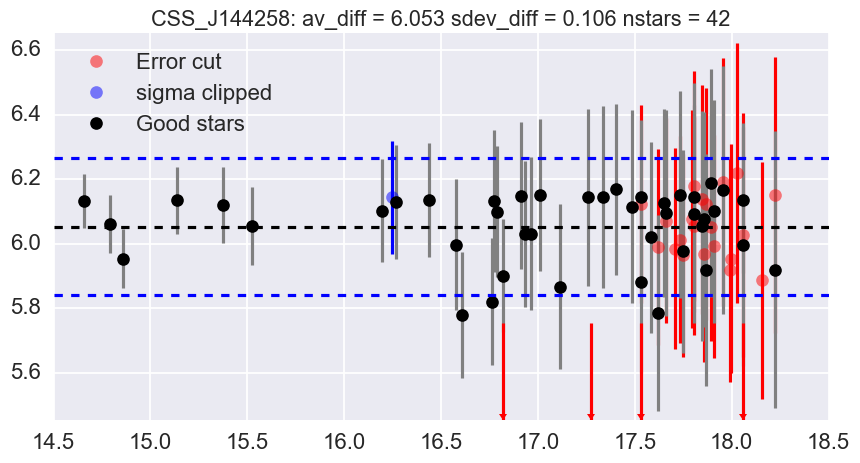

In [15]:
apcor, sdev_apcor = calculate_aperture_correction_testing.calc_apcor(flux_epoch_1, 'apcor.raw', 3, target_stem, 0.3)


Is the error cut too big here? Maybe I could decrease that to increase the number of stars that are being used because they look pretty decent. The shitty ones would be sigma clipped anyway. 

Going for 3$\sigma$ clipping, 0.3 mag error cut

In [16]:
### applying the apperture correction that was just calculated

apply_aperture_correction.apply_apcor(target_stem + '_e1_' + new_chan + '_dn.alf', apcor, num_chan)


Channel = 1


0

## This is the place where I think it was having trouble previously - calculating the offset between all the individual epochs

running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J144258_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J144258_3p6um_cal.raw     H%87  0.00 0']
3


/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calibrate_all_epochs.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mask[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1] = difference_sample[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1]
//anaconda/envs/astroconda/lib/python2.7/site-packages/numpy/ma/core.py:3289: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _data[indx] = dval
//anaconda/envs/astroconda/lib/python2.7/site-packages/numpy/ma/core.py:3290: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _mask[indx] = mval
//anaconda/envs/astroconda/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
//anaconda/envs/astroco

11
12
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e10_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e11_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e12_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e2_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e3_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e4_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e5_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e6_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e7_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e8_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e9_3p6um_dn.off
Finished offset calibration
0.00337283973 -0.148295045946
1 -0.140220907298 0.100248992365 507
2 -0.149911885246 0.0914210356558 488
3 -0.15079241517 0.0904103796522 501
4 -0.149299401198 0.104551022697 501
5 -0.145135826772 0.105521964985 508
6 -0.147414201183 0.0938054243032 507
7 -0.150298828125 0.113275704858 512
8 -0.145889546351 0.101

0

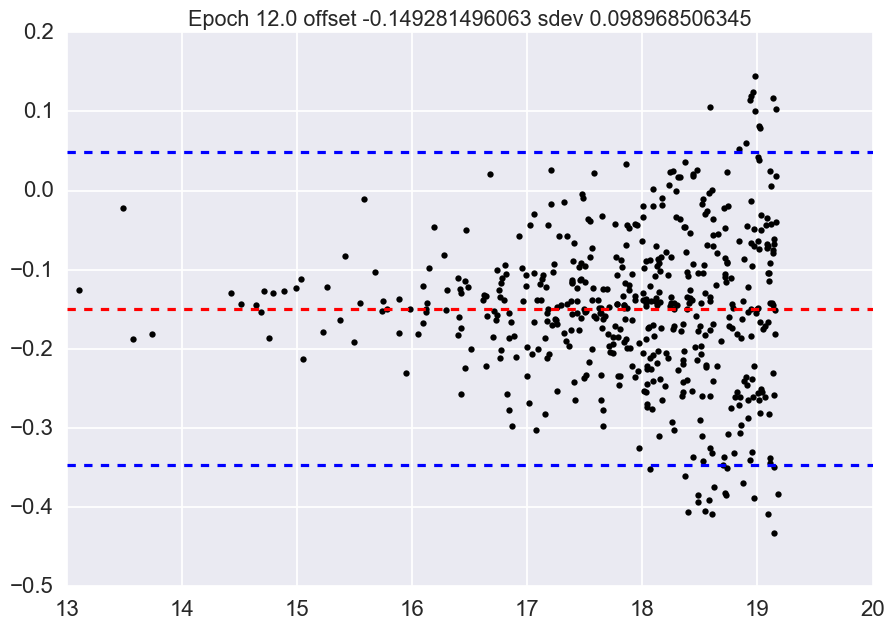

In [17]:
calibrate_all_epochs.calibrate(target_stem + '_' + new_chan + '.mch')


In [18]:
### apply the location corrections
all_location_corrections.location_corr(target_stem, new_chan)


CSS_J144258_e1_correction_3p6um.fits
CSS_J144258_e10_correction_3p6um.fits
CSS_J144258_e11_correction_3p6um.fits
CSS_J144258_e12_correction_3p6um.fits
CSS_J144258_e2_correction_3p6um.fits
CSS_J144258_e3_correction_3p6um.fits
CSS_J144258_e4_correction_3p6um.fits
CSS_J144258_e5_correction_3p6um.fits
CSS_J144258_e6_correction_3p6um.fits
CSS_J144258_e7_correction_3p6um.fits
CSS_J144258_e8_correction_3p6um.fits
CSS_J144258_e9_correction_3p6um.fits
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J144258_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J144258_3p6um.temp_cal    H%87  0.00 0']


0

# calibration should be done now, so try making a light curve

In [19]:
mch_file = target_stem + '_3p6um_cal.mch'
phot_file = target_stem + '_3p6um.cal'
mch_file = open(mch_file, 'r')
num_frames = len(glob.glob('*_dn.cal'))


file_list = []
for count in np.arange(0, num_frames):
    line = mch_file.readline()
    lines = line.split("\'")[1]
    file_list.append(lines)


times = []
num_frames = len(glob.glob('*_dn.cal'))
for name in np.arange(0, num_frames):
    fits_name = re.sub(".cal", ".fits", file_list[name])
    fits_name = re.sub(" ", "", fits_name)

    hdulist = astropy.io.fits.open(fits_name)
    prihdr = hdulist[0].header
    times.append(prihdr['date_obs'])

times = Time(times, format='isot', scale='utc')
mjds = times.mjd
print times
print mjds


['2016-05-19T07:11:16.754' '2016-05-19T15:24:46.214'
 '2016-05-19T16:19:10.171' '2016-05-19T17:17:43.132'
 '2016-05-19T08:16:02.902' '2016-05-19T09:04:58.082'
 '2016-05-19T10:00:39.429' '2016-05-19T11:03:00.788'
 '2016-05-19T11:39:38.766' '2016-05-19T12:49:12.726'
 '2016-05-19T13:43:05.487' '2016-05-19T14:32:39.644']
[ 57527.29949947  57527.64220155  57527.67997883  57527.7206381
  57527.34447803  57527.37845002  57527.41712302  57527.46042579
  57527.48586535  57527.53417507  57527.57159128  57527.6060144 ]


In [20]:
if ((num_frames % 6 ) == 0):
    n_lines_raw = int((num_frames / 6) + 1)
else:
    n_lines_raw = int(np.ceil(num_frames) / 6 + 1)
print n_lines_raw


with open(phot_file) as input:
    lines = []
    while True:
        line = list(itertools.islice(input, n_lines_raw))
        if line:
            lines.append(line)
        else:
            break
num_stars = len(lines)


3


220d44m33.522s -9d06m16.092s


INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


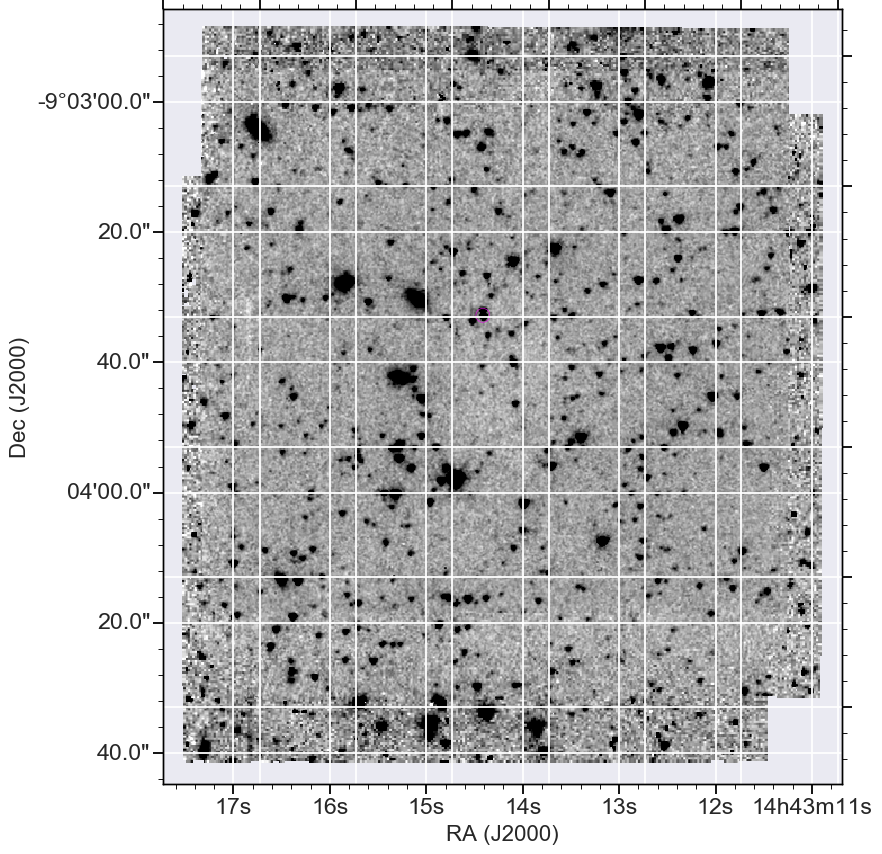

In [27]:
coords = str(target_list.ra[0]) +' ' +str(target_list.dec[0])
ra= SkyCoord(coords, unit=(u.deg, u.deg)).ra
dec = SkyCoord(coords, unit=(u.deg, u.deg)).dec
fitsfile = target_stem + '_e1_3p6um.fits'
print ra, dec


inputfile = fitsfile

fig = mp.figure(figsize=(10,10))
mosaic = aplpy.FITSFigure(inputfile, figure = fig)
mosaic.show_grayscale(vmin=0.037,vmax=0.115, invert='true') ### manually implimenting zscale
mosaic.tick_labels.set_font(size='small')
mosaic.tick_labels.set_xformat("hh:mm:ss")
mosaic.set_theme('publication')
mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='none', marker='o', s=100)
mosaic.save('testfig.pdf')

In [28]:
print inputfile

CSS_J144258_e1_3p6um.fits


In [31]:
min_distance = 10000.
rr_x, rr_y = mosaic.world2pixel(ra, dec)


objects = np.zeros((num_stars, (num_frames*2) + 3))
for star in np.arange(0,num_stars):
    data = "".join(lines[star])
    data = data.split()
    objects[star][0] = data[0] ## ID
    objects[star][1] = data[1] ## XC
    objects[star][2] = data[2] ## YC
    for epoch in np.arange(0,(num_frames*2), 2):
        objects[star][epoch + 3]  = data[epoch + 3] ## mag
        objects[star][epoch + 4] = data[epoch + 4] ## err
    distance = np.sqrt((rr_x - objects[star][1])**2 + (rr_y - objects[star][2])**2)
    if distance < min_distance:
        min_distance = distance
        best_match = objects[star][0]
        best_star = star

mag = np.zeros(num_frames)
err = np.zeros(num_frames)
for epoch in np.arange(0,num_frames):
    mag[epoch] = objects[best_star][(epoch*2) + 3]  
    err[epoch] = objects[best_star][(epoch*2) + 4] 


In [32]:
idx = np.argsort(mjds)
mjds = mjds[idx]
mag = mag[idx]
err = err[idx]


In [33]:
period = target_list.period[0]
phase = (mjds / period) - np.floor(mjds / period)
phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))


In [34]:
mag_long  = np.concatenate((mag, mag, mag, mag, mag))

err_long = np.concatenate((err, err, err, err, err))
obs = np.arange(1, num_frames+1, 1)


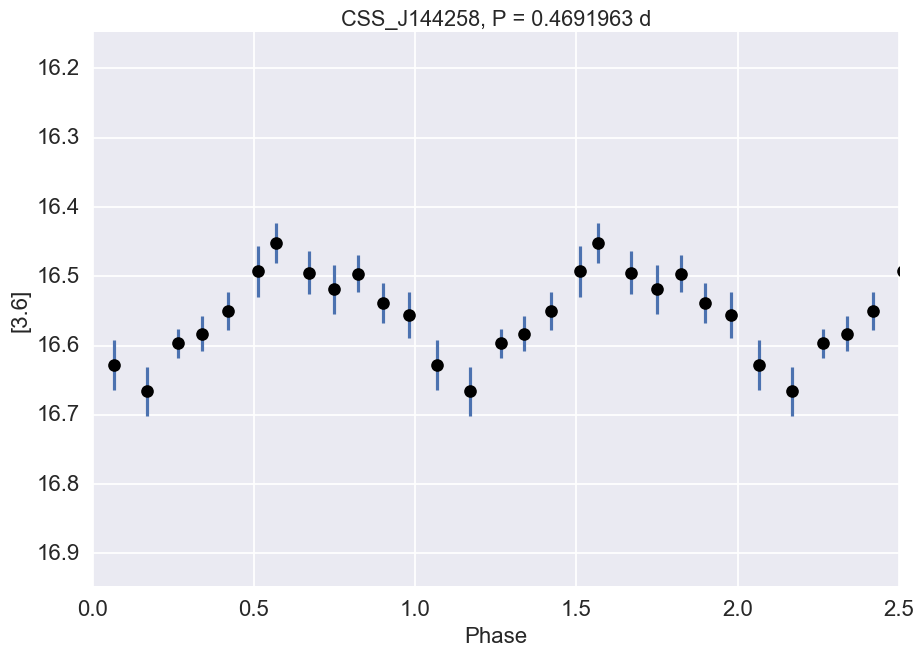

In [35]:
mp.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])
mp.errorbar(phase, mag_long, yerr=err_long, ls='None')
mp.plot(phase, mag_long, 'ko', ls='None')
mp.xlabel("Phase")
mp.ylabel('[3.6]')
mp.title(target_stem + ', P = ' + str(period) +' d')


# this looks nice. 
# What about a gloess fit? NO NOT YET DO THE OTHER ONES FIRST


# ok pipeline this shit

In [48]:
def make_rrl_finder_chart(target_stem, ra, dec):
    coords = str(ra) +' ' +str(dec)
    ra= SkyCoord(coords, unit=(u.deg, u.deg)).ra
    dec = SkyCoord(coords, unit=(u.deg, u.deg)).dec
    fitsfile = target_stem + '_e1_3p6um.fits'
    print ra, dec

    inputfile = fitsfile
    fitsdata = astropy.io.fits.open(fitsfile)[0].data
    interval = ZScaleInterval()
    zmin, zmax = interval.get_limits(fitsdata)
    
    fig = mp.figure(figsize=(10,10))
    mosaic = aplpy.FITSFigure(inputfile, figure = fig)
    mosaic.show_grayscale(vmin=zmin,vmax=zmax, invert='true') ### manually implimenting zscale
    mosaic.tick_labels.set_font(size='small')
    mosaic.tick_labels.set_xformat("hh:mm:ss")
    mosaic.set_theme('publication')
    mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='magenta', marker='o', s=100, alpha=0.3)
    mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='magenta', marker='o', s=300, alpha=0.1)
    mosaic.save(target_stem + '_location.pdf')

    

In [66]:
def find_which_star(target_stem, ra, dec):
    fitsfile = target_stem + '_e1_3p6um.fits'
    mosaic = aplpy.FITSFigure(fitsfile, figure = fig)
    rr_x, rr_y = mosaic.world2pixel(ra, dec)
    
    min_distance = 10000.
    num_frames = len(glob.glob('*_dn.cal'))
    if ((num_frames % 6 ) == 0):
        n_lines_raw = int((num_frames / 6) + 1)
    else:
        n_lines_raw = int(np.ceil(num_frames) / 6 + 1)
    print n_lines_raw
    phot_file = target_stem + '_3p6um.cal'


    with open(phot_file) as input:
        lines = []
        while True:
            line = list(itertools.islice(input, n_lines_raw))
            if line:
                lines.append(line)
            else:
                break
    num_stars = len(lines)



    objects = np.zeros((num_stars, (num_frames*2) + 3))
    for star in np.arange(0,num_stars):
        data = "".join(lines[star])
        data = data.split()
        objects[star][0] = data[0] ## ID
        objects[star][1] = data[1] ## XC
        objects[star][2] = data[2] ## YC
        for epoch in np.arange(0,(num_frames*2), 2):
            objects[star][epoch + 3]  = data[epoch + 3] ## mag
            objects[star][epoch + 4] = data[epoch + 4] ## err
        distance = np.sqrt((rr_x - objects[star][1])**2 + (rr_y - objects[star][2])**2)
        if distance < min_distance:
            min_distance = distance
            best_match = objects[star][0]
            best_star = star
    mag = np.zeros(num_frames)
    err = np.zeros(num_frames)
    for epoch in np.arange(0,num_frames):
        mag[epoch] = objects[best_star][(epoch*2) + 3]  
        err[epoch] = objects[best_star][(epoch*2) + 4] 
        
    return (mag, err)



In [67]:
def grab_mjds(mch_file):
    mch_file = open(mch_file, 'r')
    num_frames = len(glob.glob('*_dn.cal'))

    file_list = []
    for count in np.arange(0, num_frames):
        line = mch_file.readline()
        lines = line.split("\'")[1]
        file_list.append(lines)
    times = []
    num_frames = len(glob.glob('*_dn.cal'))
    for name in np.arange(0, num_frames):
        fits_name = re.sub(".cal", ".fits", file_list[name])
        fits_name = re.sub(" ", "", fits_name)

        hdulist = astropy.io.fits.open(fits_name)
        prihdr = hdulist[0].header
        times.append(prihdr['date_obs'])

    times = Time(times, format='isot', scale='utc')
    mjds = times.mjd
    return(mjds)

    

In [68]:
def plot_a_lc(target_stem, period, mjds, mag, err):
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]

    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))

    mag_long  = np.concatenate((mag, mag, mag, mag, mag))

    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)

    mp.close()
    mp.clf()
    mp.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])
    mp.errorbar(phase, mag_long, yerr=err_long, ls='None')
    mp.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    mp.ylabel('[3.6]')
    mp.title(target_stem + ', P = ' + str(period) +' d')
    outplot = target_stem + '_lc.pdf'
    mp.savefig(outplot)
    
    output = target_stem + '_rrlyrae.data'
    output_file = open(output, "w")

    for frame in np.arange(0, num_frames):
        output_file.write("{0:.8f} {1:.3f} {2:.3f} \n".format(mjds[frame], mag[frame], err[frame]))

    output_file.close()

    

In [69]:
def calibrate_and_plot(row):
    target_name = row['survey_ident']
    ra = row['ra']
    dec = row['dec']
    period = row['period']

    channel = 1 ### hardwired to channel 1 here
    if (channel == 1 or channel == '3p6um' or channel == '1'): new_chan = '3p6um'
    elif (channel == 2 or channel == '4p5um' or channel == '2'): new_chan = '4p5um'
    else: 
        print 'invalid channel'
        exit(1)

    if new_chan == '3p6um': num_chan = 1
    if new_chan == '4p5um': num_chan = 2
    target_stem = sgr_setup.get_target_stem(target_name)
    dir_name = re.sub('\.', '_', target_name)
    dir_name = re.sub('-', '', dir_name)
    directory = '/Users/vs/Dropbox/TRACCS/TRACCS_Output/' + dir_name + '/' + dir_name + '_' + new_chan
    os.chdir(directory)
    if (len(glob.glob(target_stem + '*' + new_chan +'*.alf'))==0):
        print 'You need to run ALLFRAME before you can calibrate the photometry'
        print 'This is the CALIBRATION ONLY script'
        print 'Run ``globular_pipeline_anychannel.py`` to do the combined photometry and calibration script'
        exit(1)
    flux_epoch_1 = target_stem + '_e1_' + new_chan
    aperture_correction_photometry.apcor_photo(flux_epoch_1)
    apcor, sdev_apcor = calculate_aperture_correction_testing.calc_apcor(flux_epoch_1, 'apcor.raw', 3, target_stem, 0.3)
    apply_aperture_correction.apply_apcor(target_stem + '_e1_' + new_chan + '_dn.alf', apcor, num_chan)
    calibrate_all_epochs.calibrate(target_stem + '_' + new_chan + '.mch')
    all_location_corrections.location_corr(target_stem, new_chan)
    
    
    make_rrl_finder_chart(target_stem, ra, dec)

    mch_file = target_stem + '_3p6um_cal.mch'
    phot_file = target_stem + '_3p6um.cal'


    mag, err = find_which_star(target_stem, ra, dec)
    mjds = grab_mjds(mch_file)
    
    plot_a_lc(target_stem, period, mjds, mag, err)


should have made this part of the code modular.... do it now

actually most of it already is. it's just the light curve part that isn't. fix that shit

In [70]:
top_row = target_list.head(2)

In [71]:
top_row

,survey_ident,period,vmag,ra,dec,target_name
0,CSS_J144258.2-090616,0.469196,17.254,220.742645,-9.10447,Pal5_03
1,CSS_J145408.5-051633,0.568599,17.398,223.535782,-5.27594,Pal5_05


0.11971008602530572

In [ ]:
target_list.apply(lambda line: calibrate_and_plot(line), axis=1)

2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

INFO:astropy:Auto-setting resolution to 77.9355 dpi


 -9d06m16.092s
INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J145408_e1_3p6um
at CSS_J145408_e1_3p6um

     CSS_J145408_e1_3p6um...                 


                                      Picture size:    604   

INFO:astropy:Auto-setting resolution to 77.9355 dpi


INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J134430_e1_3p6um
at CSS_J134430_e1_3p6um

     CSS_J134430_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 86 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 86 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


Channel = 1
running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J134430_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J134430_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e10_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e11_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e12_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e2_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e3_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e4_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e5_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e6_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e7_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e8_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e9_3p6um_dn.off
Finished offset calibration
0.00698120865542 -0.161745510297
1 -0.14820626151 0.106638706902 543

INFO:astropy:Auto-setting resolution to 77.9355 dpi


 -5d20m47.148s
INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J151101_e1_3p6um
at CSS_J151101_e1_3p6um

     CSS_J151101_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


Channel = 1
running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J151101_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J151101_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e10_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e11_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e12_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e2_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e3_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e4_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e5_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e6_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e7_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e8_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e9_3p6um_dn.off
Finished offset calibration
0.678637673838 0.0472227219803
1 -0.168670682731 0.112348014175 498


INFO:astropy:Auto-setting resolution to 77.9355 dpi


INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J152902_e1_3p6um
at CSS_J152902_e1_3p6um

     CSS_J152902_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


Channel = 1
running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J152902_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J152902_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e10_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e11_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e12_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e2_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e3_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e4_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e5_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e6_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e7_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e8_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e9_3p6um_dn.off
Finished offset calibration
0.00352358557776 -0.155125578923
1 -0.154435064935 0.0962531784144 6

INFO:astropy:Auto-setting resolution to 77.9355 dpi


INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J153528_e1_3p6um
at CSS_J153528_e1_3p6um

     CSS_J153528_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 59 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 59 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


Channel = 1
running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J153528_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J153528_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e10_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e11_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e12_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e2_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e3_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e4_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e5_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e6_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e7_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e8_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e9_3p6um_dn.off
Finished offset calibration
0.00500480507714 -0.164826665191
1 -0.170044326241 0.105732717782 56

INFO:astropy:Auto-setting resolution to 77.9355 dpi


 3d30m05.616s
INFO: Auto-setting resolution to 77.9355 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155355_e1_3p6um
at CSS_J155355_e1_3p6um

     CSS_J155355_e1_3p6um...                 


                                      Picture size:    695   

/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 87 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 87 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


Channel = 1
running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J155355_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J155355_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e10_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e11_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e12_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e2_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e3_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e4_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e5_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e6_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e7_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e8_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e9_3p6um_dn.off
Finished offset calibration
0.0105195089666 1.29256604621
1 1.29917380952 0.0919254396613 420
2 

238d28m56.388s 5d37m41.448s


INFO:astropy:Auto-setting resolution to 89.6774 dpi


INFO: Auto-setting resolution to 89.6774 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155742_e1_3p6um
at CSS_J155742_e1_3p6um

     CSS_J155742_e1_3p6um...                 


                                      Picture size:    604   

In [65]:
os.getcwd()


'/Users/vs/Dropbox/TRACCS/TRACCS_Output/CSS_J145408_5051633/CSS_J145408_5051633_3p6um'